In [13]:
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [32]:
df = pd.read_csv("data/precipitation.csv")
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

In [33]:
class PrecipitacionRegresion:
    def __init__(self, df1, df2, df3):
        # Inicialización de los DataFrames
        self.df_train_1 = df1
        self.df_train_2 = df2
        self.df_test = df3

        # Preprocesamiento de los DataFrames
        self._preprocess_data()

        # Crear el tipo de individuo para DEAP
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        # Representamos a los individuos como una lista de coeficientes [coef_intercepto, coef_pendiente]
        self.toolbox.register("attr_float", np.random.uniform, -10, 10)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attr_float, n=2)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

    def _preprocess_data(self):
        # Convertir las fechas a datetime para cada dataframe
        self.df_train_1['date'] = pd.to_datetime(self.df_train_1['date'], format='%d/%m/%Y')
        self.df_train_2['date'] = pd.to_datetime(self.df_train_2['date'], format='%d/%m/%Y')
        self.df_test['date'] = pd.to_datetime(self.df_test['date'], format='%d/%m/%Y')

        # Agregar columna de mes
        self.df_train_1['month'] = self.df_train_1['date'].dt.month
        self.df_train_2['month'] = self.df_train_2['date'].dt.month
        self.df_test['month'] = self.df_test['date'].dt.month

        # Agrupar los datos por mes y calcular el promedio de precipitación
        self.df_train_avg_1 = self.df_train_1.groupby('month')['precipitation'].mean().reset_index()
        self.df_train_avg_2 = self.df_train_2.groupby('month')['precipitation'].mean().reset_index()
        self.df_test_avg = self.df_test.groupby('month')['precipitation'].mean().reset_index()

        # Vamos a trabajar con los datasets agrupados por mes
        self.df_train = pd.concat([self.df_train_avg_1, self.df_train_avg_2])  # Datos de entrenamiento
        self.X_train = self.df_train[['month']].values  # La columna "month" será el predictor
        self.y_train = self.df_train['precipitation'].values  # El objetivo es la precipitación

        self.X_test = self.df_test_avg[['month']].values  # Usaremos los meses de test
        self.y_test = self.df_test_avg['precipitation'].values

    def evaluate(self, individual):
        # Coeficientes de la regresión lineal
        intercept, slope = individual
        y_pred = intercept + slope * self.X_train.flatten()  # y = intercepto + pendiente * X
        mse = mean_squared_error(self.y_train, y_pred)
        return mse,

    def entrenar(self, n_generations=100, population_size=200, cx_prob=0.5, mut_prob=0.2):
        # Registro de operaciones en DEAP
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate)

        # Parámetros del algoritmo genético
        population = self.toolbox.population(n=population_size)

        # Ejecución del algoritmo genético
        result = algorithms.eaSimple(population, self.toolbox, cxpb=cx_prob, mutpb=mut_prob, ngen=n_generations, 
                                      verbose=True)

        # Extraer el mejor individuo (los mejores coeficientes)
        self.best_individual = tools.selBest(population, k=1)[0]
        self.best_intercept, self.best_slope = self.best_individual

        # Usar los coeficientes para hacer predicciones en el dataset de prueba
        self.y_pred_test = self.best_intercept + self.best_slope * self.X_test.flatten()
        self.y_pred_test = self.y_pred_test.flatten()

        # Calcular el error cuadrático medio para las predicciones en el test
        self.mse_test = mean_squared_error(self.y_test, self.y_pred_test)
        print(f"Mejor intercepto: {self.best_intercept}, Mejor pendiente: {self.best_slope}")
        print(f"Error cuadrático medio en test: {self.mse_test}")

        # Mostrar la ecuación de la regresión
        print(f"Ecuación de la regresión: y = {self.best_slope:.2f} * x + {self.best_intercept:.2f}")

    def get_maximo(self):
        """Retorna el valor máximo de la función de regresión."""
        return self.best_slope * 12 + self.best_intercept  # Maximo para el mes 12

    def get_minimo(self):
        """Retorna el valor mínimo de la función de regresión."""
        return self.best_slope * 1 + self.best_intercept  # Minimo para el mes 1

    def plot_results(self):
        """Método para graficar los resultados de las predicciones."""
        plt.plot(self.df_test_avg['month'], self.y_test, label='Real')
        plt.plot(self.df_test_avg['month'], self.y_pred_test, label='Predicción', linestyle='--')
        plt.xlabel('Mes')
        plt.ylabel('Precipitación')
        plt.title('Predicciones de Precipitación vs Valores Reales')
        plt.legend()
        plt.show()


C:\Users\Trabajo - Agustin\AppData\Local\Temp\ipykernel_11572\1733663595.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_train_1['date'] = pd.to_datetime(self.df_train_1['date'], format='%d/%m/%Y')
C:\Users\Trabajo - Agustin\AppData\Local\Temp\ipykernel_11572\1733663595.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_train_2['date'] = pd.to_datetime(self.df_train_2['date'], format='%d/%m/%Y')
C:\Users\Trabajo - Agustin\AppData\Local\Temp\ipykernel_11572\1733663595.py:25: SettingWit

gen	nevals
0  	200   
1  	122   
2  	117   
3  	136   
4  	129   
5  	115   
6  	127   
7  	110   
8  	132   
9  	137   
10 	120   
11 	115   
12 	123   
13 	128   
14 	125   
15 	117   
16 	121   
17 	111   
18 	111   
19 	126   
20 	123   
21 	119   
22 	126   
23 	117   
24 	129   
25 	123   
26 	132   
27 	106   
28 	102   
29 	116   
30 	118   
31 	107   
32 	109   
33 	128   
34 	114   
35 	127   
36 	125   
37 	117   
38 	114   
39 	119   
40 	111   
41 	122   
42 	121   
43 	119   
44 	122   
45 	124   
46 	99    
47 	115   
48 	114   
49 	117   
50 	130   
51 	120   
52 	114   
53 	110   
54 	129   
55 	99    
56 	122   
57 	118   
58 	122   
59 	100   
60 	131   
61 	120   
62 	129   
63 	132   
64 	108   
65 	120   
66 	111   
67 	104   
68 	110   
69 	117   
70 	130   
71 	120   
72 	120   
73 	112   
74 	132   
75 	108   
76 	120   
77 	116   
78 	124   
79 	121   
80 	114   
81 	114   
82 	111   
83 	121   
84 	137   
85 	125   
86 	119   
87 	118   
88 	102   
89 	119   

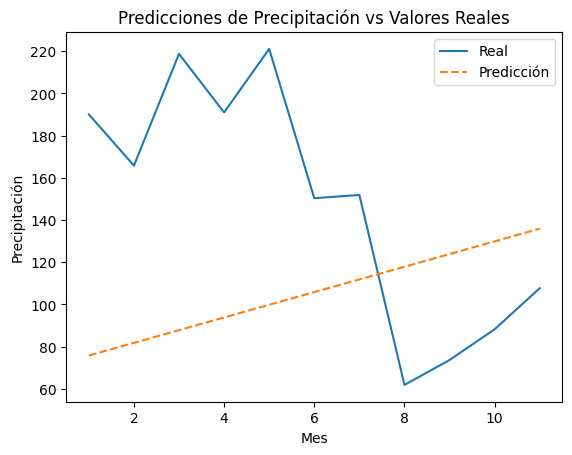

In [42]:
# Ejemplo de uso:
df_2015 = df[df['date'].dt.year == 2015]
df_2016 = df[df['date'].dt.year == 2016]
df_2017 = df[df['date'].dt.year == 2017]

precipitacion_model = PrecipitacionRegresion(df_2015, df_2016, df_2017)
precipitacion_model.entrenar()
print("Máximo Predicho:", precipitacion_model.get_maximo())
print("Mínimo Predicho:", precipitacion_model.get_minimo())
precipitacion_model.plot_results()